# RNA velocity with VeloCycle

The cell cycle is an interesting case for RNA velocity estimation, as pseudotime methods along often fail as estimations of cyclical processes. Moreover, RNA velocity corresponds roughly to cell cycle speed, which is both experimentally verifiable. The cell cycle also unfolds on a timescale of less than 24 hours, which is well suited for studying cell dynamics using RNA lifecycle kinetics, such as with RNA velocity. 

A recent method has been developed called **VeloCycle** to estimate RNA velocity of the cell cycle on the real time scale. This method offers several advantages over existing approaches:
- The ability to estimate uncertainty of velocity estimates (i.e. velocity confidence).
- The ability to estimate both the low dimensional manifold and the velocity jointly.
- The ability to perform statistical tests of velocity between conditions.
- The ability to convert velocity estimates to a "real" time scale.

Comparing cell cycle velocities might be useful in a variable of scientific contexts:
- Do two cancer subtumors proliferate as similar speeds?
- Does a particular gene knockout or mutant impact the cell cycle speed?
- Do progenitor cells in different regions of an organ (i.e., brain) or at different developmental stages divide equally quickly?

Here, we will offer a short tutorial into VeloCycle, using the ductal cells from the pancreas dataset above. This will also offer insight into probabilistic modeling in Pyro, which is an advanced method used by many tools for modeling complex biological data.

In [1]:
import velocycle as vcy
import scvelo as scv
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from velocycle import *
import anndata
import pyro
import torch
import copy

In [2]:
adata_raw = scv.datasets.pancreas()
adata_cycling = adata_raw[adata_raw.obs["clusters"].isin(["Ductal"])].copy()
adata_cycling

AnnData object with n_obs × n_vars = 916 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

## Load and filter dataset

In [3]:
adata = adata_cycling.copy()

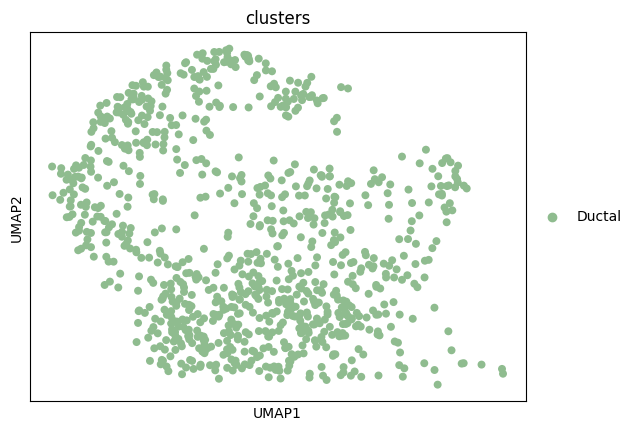

In [4]:
sc.pl.umap(adata, color='clusters')

In [5]:
full_adatas = {"pancreas_ductal":adata[adata.obs["clusters"].isin(["Ductal"])].copy()}

In [6]:
# Filter lowly-expressed genes and concatenate all datasets
for a in full_adatas.keys(): 
    print(full_adatas[a].shape)
    sc.pp.filter_genes(full_adatas[a], min_cells=int((full_adatas[a].n_obs)*0.10))
    
data = anndata.concat(full_adatas, label="batch", join ="outer")

(916, 27998)


In [7]:
# Perform some very basic gene filtering by unspliced counts
data = data[:, (data.layers["unspliced"].toarray().mean(0) > 0.1)].copy()

# Perform some very basic gene filtering by spliced counts
data = data[:, data.layers["spliced"].toarray().mean(0) > 0.2].copy()

In [8]:
data.var.index = [i.upper() for i in data.var.index]
data

AnnData object with n_obs × n_vars = 916 × 1394
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'batch'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

In [9]:
# Create design matrix for dataset with a single batch
batch_design_matrix = preprocessing.make_design_matrix(data, ids="batch")

In [10]:
# Rough approximation of the cell cycle phase using categorical approaches 
sc.tl.score_genes_cell_cycle(data, s_genes=utils.S_genes_human, g2m_genes=utils.G2M_genes_human)

In [11]:
# Create size-normalized data layers
preprocessing.normalize_total(data)

In [12]:
# Get biologically-relevant gene set to use for velocity estimation
full_keep_genes = utils.get_cycling_gene_set(size="Medium", species="Human")

# Initialize cycle and phase objects with priors

In [13]:
n_harm = 1
cycle_prior = cycle.Cycle.trivial_prior(gene_names=full_keep_genes, harmonics=n_harm)
cycle_prior, data_to_fit = preprocessing.filter_shared_genes(cycle_prior, data, filter_type="intersection")

In [14]:
# Update the priors for gene harmonics
# to gene-specific means and stds
S = data_to_fit.layers['spliced'].toarray()
S_means = S.mean(axis=0) #sum over cells
nu0 = np.log(S_means)
nu0std = np.std(np.log(S+1), axis=0)/2

S_frac_means=np.vstack((nu0, 0*nu0, 0*nu0))
cycle_prior.set_means(S_frac_means)

S_frac_stds=np.vstack((nu0std, 0.5*nu0std, 0.5*nu0std))
cycle_prior.set_stds(S_frac_stds)

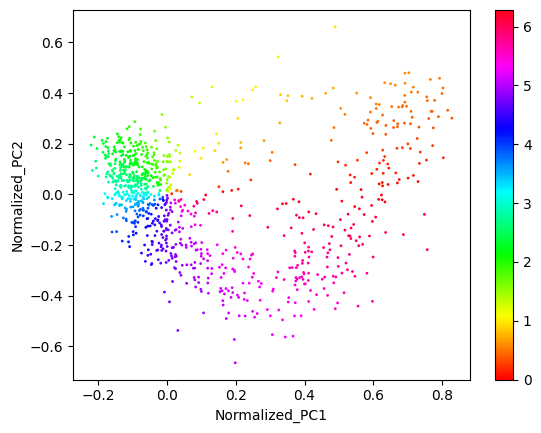

In [15]:
# Obtain a PCA prior for individual cell phases
phase_prior = phases.Phases.from_pca_heuristic(data_to_fit, 
                                               concentration=5.0, 
                                               plot=True, 
                                               small_count=1)

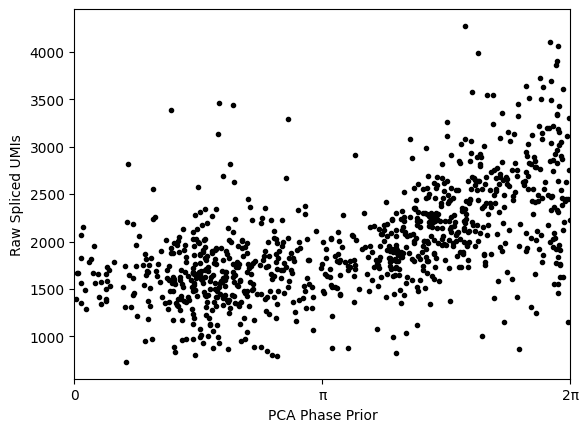

In [16]:
# Shift the phase prior to have maximum correlation with the total raw UMI counts
(shift, maxcor, allcor) = phase_prior.max_corr(data_to_fit.obs.n_scounts)
phase_prior.rotate(angle=-shift)
plt.plot(phase_prior.phis, data_to_fit.obs.n_scounts, '.', c='black')
plt.xlim(0, np.pi*2)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"])
plt.xlabel("PCA Phase Prior")
plt.ylabel("Raw Spliced UMIs")
plt.show()

## Run the manifold-learning module

In [17]:
pyro.clear_param_store()

In [18]:
# Set batch effect to zero because there is only a single dataset/batch
Δν = torch.zeros((batch_design_matrix.shape[1], S.shape[1], 1)).float()
condition_on_dict = {"Δν": Δν}

In [19]:
metapar = preprocessing.preprocess_for_phase_estimation(anndata=data_to_fit, 
                                          cycle_obj=cycle_prior, 
                                          phase_obj=phase_prior, 
                                          design_mtx=batch_design_matrix,
                                          n_harmonics=n_harm,
                                          condition_on=condition_on_dict)

In [20]:
phase_fit = phase_inference_model.PhaseFitModel(metaparams=metapar, 
                                                condition_on=condition_on_dict)
phase_fit.check_model()

 Trace Shapes:                          
  Param Sites:                          
 Sample Sites:                          
    cells dist            |             
         value        916 |             
    genes dist            |             
         value         61 |             
  batches dist            |             
         value          1 |             
        ν dist     61   1 |   3         
         value     61   1 |   3         
       Δν dist   1 61   1 |             
         value   1 61   1 |             
      ϕxy dist        916 |   2         
         value        916 |   2         
        ϕ dist            | 916         
         value            | 916         
        ζ dist            | 916 3       
         value            | 916 3       
    ElogS dist            |   1 1 61 916
         value            |   1 1 61 916
shape_inv dist     61   1 |             
         value     61   1 |             
        S dist 1 1 61 916 |             
         value  

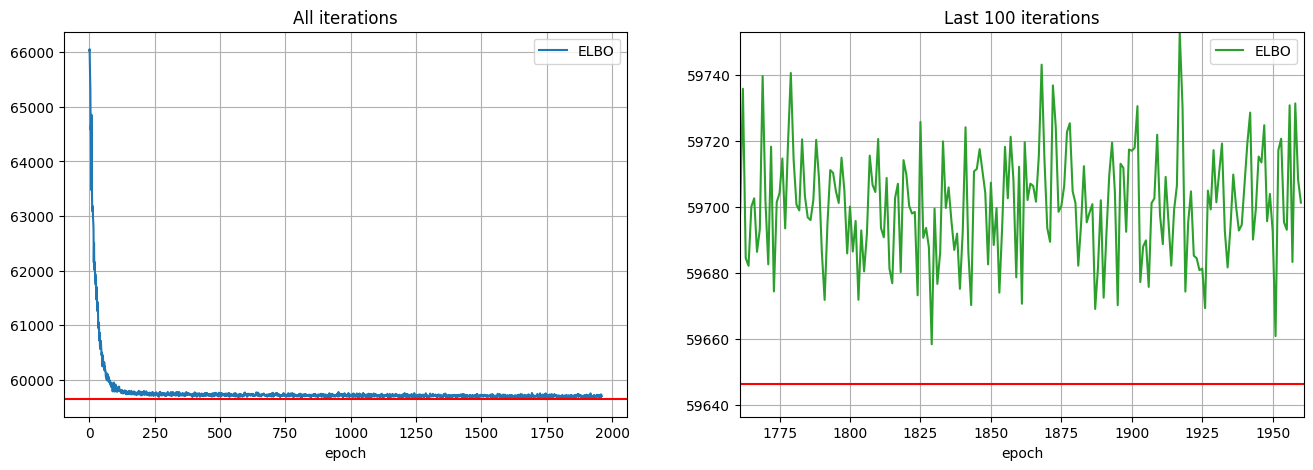

In [21]:
num_steps = 1000
initial_lr = 0.03
final_lr = 0.005
gamma = final_lr / initial_lr
lrd = gamma ** (1 / num_steps)
adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

phase_fit.fit(optimizer=adam, num_steps=num_steps)

## Visualize the results

In [22]:
# Put estimations in new objects
cycle_pyro = phase_fit.cycle_pyro
phase_pyro = phase_fit.phase_pyro

In [23]:
fit_ElogS = phase_fit.posterior["ElogS"].squeeze().numpy()
fit_ElogS2 = phase_fit.posterior["ElogS2"].squeeze().numpy()

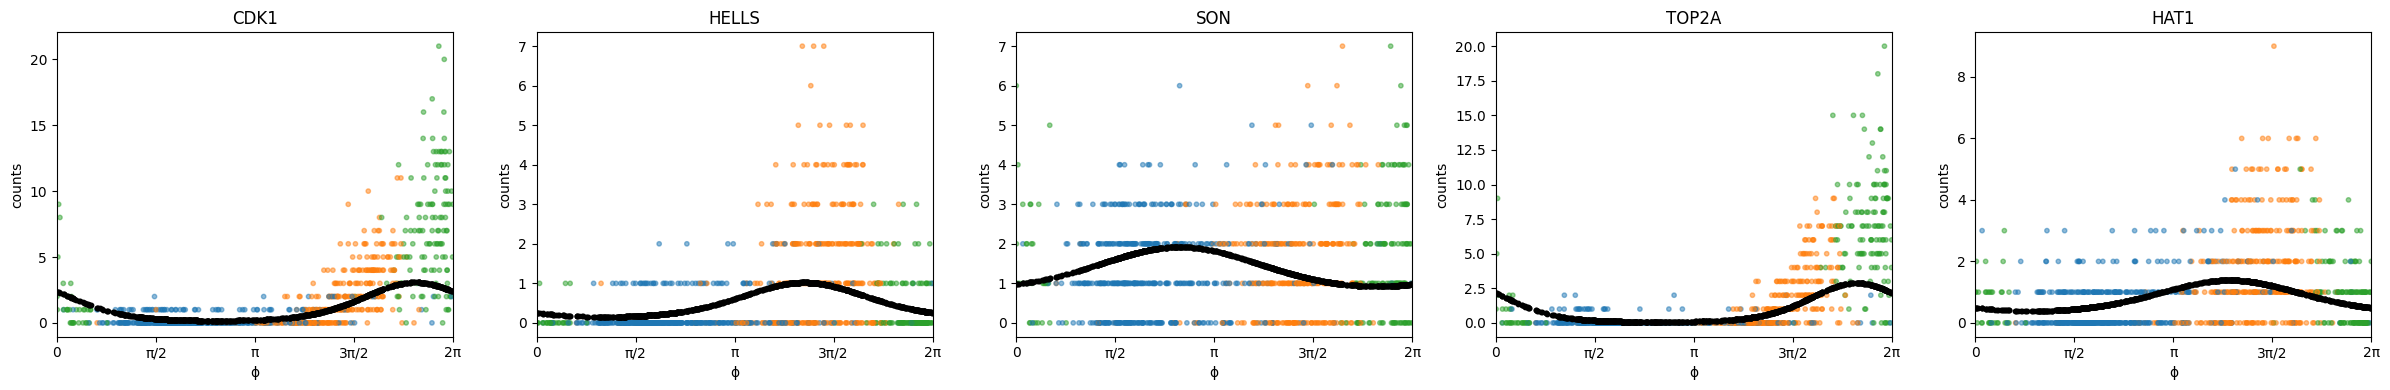

In [24]:
name2color = {'G1':"tab:blue", 'S':"tab:orange", 'G2M':"tab:green"}
gene_list = ["CDK1", "HELLS", "SON", "TOP2A", "HAT1"]
gene_names = np.array(data_to_fit.var.index)
plt.figure(None,(24, 4))
ix = 1
for i in range(0, len(gene_list)):
    g = gene_list[i]
    plt.subplot(1, len(gene_list), ix)
    plt.scatter(phase_pyro.phis, 
                metapar.S[np.where(gene_names==g)[0][0], :].squeeze().cpu().numpy(), 
                s=10, alpha=0.5, c=[name2color[x] for x in data_to_fit.obs["phase"]])
    plt.scatter(phase_pyro.phis, 
                np.exp(fit_ElogS2[np.where(gene_names==g)[0][0], :]), 
                s=10, c="black")
    plt.title(g)
    plt.xlabel("ϕ")
    plt.ylabel("counts")
    ix+=1
    plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"])
    plt.xlim(0, 2*np.pi)
plt.tight_layout()
plt.show()

In [25]:
xs = phase_fit.fourier_coef[1]
ys = phase_fit.fourier_coef[2]
r = np.log10( np.sqrt(xs**2+ys**2) / phase_fit.fourier_coef_sd[1:, :].sum(0) )
angle = np.arctan2(xs, ys)
angle = (angle)%(2*np.pi)

phis_df = pd.DataFrame([angle, r])
phis_df.columns = data_to_fit.var.index

phase_data_frame = pd.concat([phase_fit.cycle_pyro.means, phase_fit.cycle_pyro.stds, phis_df]).T
phase_data_frame.columns = ["nu0 mean", "nu1sin mean", "nu1cos mean",
                            "nu0 std", "nu1sin std", "nu1cos std", "peak_phase", "amplitude"]
phase_data_frame["is_seurat_marker"] = [True if i in list(utils.S_genes_human)+list(utils.G2M_genes_human) else False for i in phase_data_frame.index]
phase_data_frame.head()

phis_df = pd.DataFrame(phase_fit.phase_pyro.phis.numpy())
phis_df.index = data_to_fit.obs.index
phis_df.columns = ["cell_cycle_phi"]
phase_data_frame_cells = data_to_fit.obs.merge(phis_df, left_index=True, right_index=True)

In [26]:
# Define the number of bins
num_bins = 10
bin_width = 2 * np.pi / num_bins

# Calculate the bin index for each gene
phase_data_frame['bin_index'] = ((phase_data_frame['peak_phase'] + 2 * np.pi) % (2 * np.pi) / bin_width).astype(int)

# Group genes by bin index and find top 10 genes in each bin
top_genes_per_bin = phase_data_frame.groupby('bin_index', group_keys=False).apply(lambda group: group.nlargest(5, 'amplitude'))

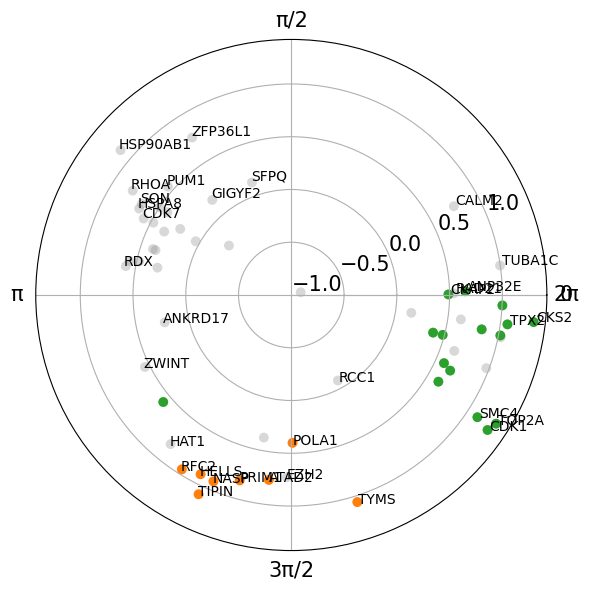

In [27]:
keep_genes = [a.upper() for a in cycle_prior.means.columns]

gene_names = np.array(keep_genes)

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.transforms as mtransforms
import seaborn as sns

keep_genes = [a.upper() for a in cycle_prior.means.columns]
gene_names = np.array(keep_genes)
S_genes_human = list(utils.S_genes_human)
G2M_genes_human = list(utils.G2M_genes_human)
phases_list = [S_genes_human, G2M_genes_human, [i.upper() for i in gene_names if i.upper() not in S_genes_human+G2M_genes_human]]

g = []
gradient = []
for i in range(len(phases_list)):
    for j in range(len(phases_list[i])):
        g.append(phases_list[i][j])
        gradient.append(i)

color_gradient_map = pd.DataFrame({'Gene': g,  'Color': gradient}).set_index('Gene').to_dict()['Color']
colored_gradient = pd.Series(gene_names).map(color_gradient_map)

xs = phase_fit.fourier_coef[1]
ys = phase_fit.fourier_coef[2]
r = np.log10( np.sqrt(xs**2+ys**2) / phase_fit.fourier_coef_sd[1:, :].sum(0) )
angle = np.arctan2(xs, ys)
angle = (angle)%(2*np.pi)

N=50
width = (2*np.pi) / N

fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(projection='polar')

# First: only plot dots with a color assignment
angle_subset = angle[~np.isnan(colored_gradient.values)]
r_subset = r[~np.isnan(colored_gradient.values)]
color_subset = colored_gradient.values[~np.isnan(colored_gradient.values)]

# Remove genes with very low expression
angle_subset = angle_subset[r_subset>=-12]
color_subset = color_subset[r_subset>=-12]
gene_names_subset = gene_names[r_subset>=-12]
r_subset = r_subset[r_subset>=-12]

x=100
# Take a subset of most highly expressing genes to print the names 
angle_subset_best = angle_subset[r_subset>np.percentile(r_subset, x)]
color_subset_best = color_subset[r_subset>=np.percentile(r_subset, x)]
gene_names_subset_best = gene_names_subset[r_subset>=np.percentile(r_subset, x)]
r_subset_best = r_subset[r_subset>=np.percentile(r_subset, x)]

# Plot all genes in phases list
num2color = {0:"tab:orange", 1:"tab:green", 2:"tab:grey", 3:"tab:blue"}
ax.scatter(angle_subset, r_subset, c=[num2color[i] for i in color_subset], s=50, alpha=0.3, edgecolor='none', rasterized=True)

# Select and plot on top the genes marking S and G2M traditionally
angle_subset = angle_subset[color_subset!=2]
r_subset = r_subset[color_subset!=2]
gene_names_subset = gene_names_subset[color_subset!=2]
color_subset = color_subset[color_subset!=2]

ax.scatter(angle_subset, r_subset, c=[num2color[i] for i in color_subset], s=50, alpha=1, edgecolor='none',rasterized=True)

# Annotate genes
for (i, txt), c in zip(enumerate(gene_names), colored_gradient.values):
    if txt in top_genes_per_bin.index:
        ix = np.where(np.array(gene_names)==txt)[0][0]
        ax.annotate(txt[0]+txt[1:].upper(), (angle[ix], r[ix]+0.02))

plt.xlim(0, 2*np.pi)
plt.ylim(-1, )
plt.yticks([-1, -0.5, 0, 0.5, 1], size=15)
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"], size=15)
plt.tight_layout()
plt.show()

## Run the velocity-learning module

In [28]:
pyro.clear_param_store()

In [29]:
condition_design_matrix = copy.deepcopy(batch_design_matrix)

In [30]:
n_velo_harmonics = 0
speed_prior = angularspeed.AngularSpeed.trivial_prior(condition_names=["pancreas_ductal"], 
                                                      harmonics=n_velo_harmonics)

In [31]:
condition_on_dict = {"ϕxy":phase_pyro.phi_xy_tensor.T,
                     "ν": cycle_pyro.means_tensor.T.unsqueeze(-2),
                     "Δν": torch.tensor(phase_fit.delta_nus),
                     "shape_inv": torch.tensor(phase_fit.disp_pyro).unsqueeze(-1)}

In [32]:
metaparameters_velocity = preprocessing.preprocess_for_velocity_estimation(data_to_fit, 
                                                             cycle_pyro, 
                                                             phase_pyro, 
                                                             speed_prior,
                                                             condition_design_matrix.float(), 
                                                             batch_design_matrix.float(), 
                                                             n_harmonics=n_harm,
                                                             count_factor=metapar.count_factor,
                                                             ω_n_harmonics=n_velo_harmonics, 
                                                             μγ=torch.tensor(0.0).detach().clone().float(),
                                                             σγ=torch.tensor(0.5).detach().clone().float(),
                                                             μβ=torch.tensor(2.0).detach().clone().float(),
                                                             σβ=torch.tensor(3.0).detach().clone().float(),
                                                             model_type="lrmn",
                                                             condition_on=condition_on_dict)

In [33]:
velocity_fit = velocity_inference_model.VelocityFitModel(metaparams=metaparameters_velocity, 
                                                         condition_on=condition_on_dict)

In [34]:
velocity_fit.check_model()

  Trace Shapes:                              
   Param Sites:                              
  Sample Sites:                              
     cells dist              |               
          value          916 |               
     genes dist              |               
          value           61 |               
 harmonics dist              |               
          value            1 |               
conditions dist              |               
          value            1 |               
   batches dist              |               
          value            1 |               
     logγg dist       61   1 |               
          value       61   1 |               
     logβg dist       61   1 |               
          value       61   1 |               
  rho_real dist       61   1 |               
          value       61   1 |               
        γg dist       61   1 |  61   1       
          value              |  61   1       
         ν dist       61   1 |   3

In [35]:
velocity_fit.check_guide()

  Trace Shapes:              
   Param Sites:              
         ν_locs     61   1  3
       ν_scales     61   1  3
        Δν_locs 1 1  1  61  1
       ϕxy_locs        916  2
     logβg_locs         61  1
   logβg_scales         61  1
            loc            62
     cov_factor         62  5
       cov_diag            62
   rho_real_loc            61
 shape_inv_locs         61  1
  Sample Sites:              
     cells dist             |
          value        916  |
     genes dist             |
          value         61  |
 harmonics dist             |
          value          1  |
conditions dist             |
          value          1  |
   batches dist             |
          value          1  |
     logγg dist     61   1  |
          value     61   1  |
  rho_real dist     61   1  |
          value     61   1  |
     logβg dist     61   1  |
          value     61   1  |
        νω dist 1 1  1   1  |
          value 1 1  1   1  |


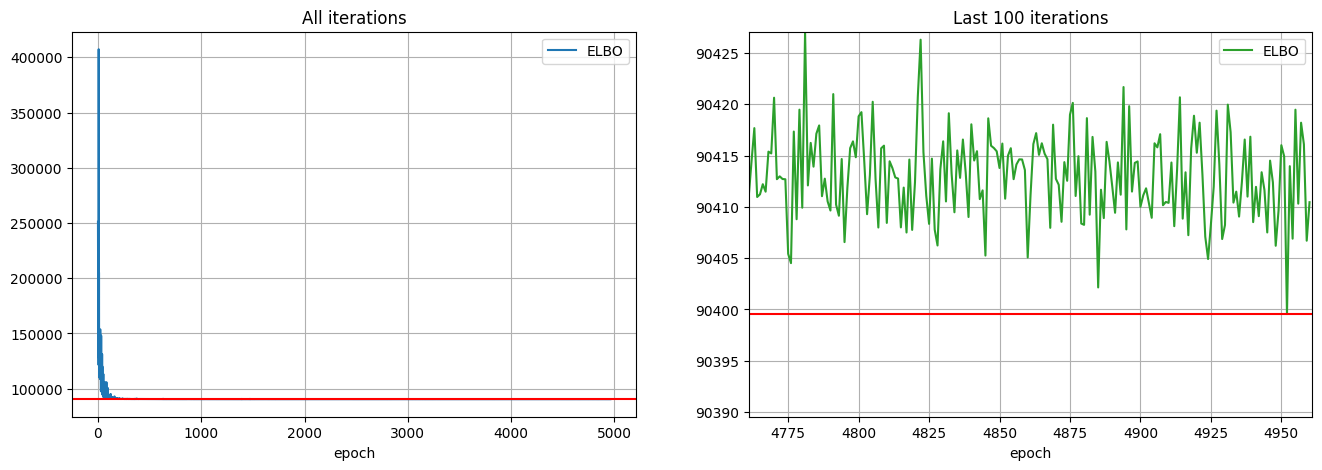

In [36]:
num_steps = 3000
initial_lr = 0.03
final_lr = 0.005
gamma = final_lr / initial_lr
lrd = gamma ** (1 / num_steps)
adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

velocity_fit.fit(optimizer=adam, num_steps=num_steps)

In [37]:
# Put estimations in new objects
cycle_pyro = velocity_fit.cycle_pyro
phase_pyro = velocity_fit.phase_pyro
speed_pyro = velocity_fit.speed_pyro

fit_ElogS = velocity_fit.posterior["ElogS"].squeeze()
fit_ElogU = velocity_fit.posterior["ElogU"].squeeze()

fit_ElogS2 = velocity_fit.posterior["ElogS2"].squeeze()
fit_ElogU2 = velocity_fit.posterior["ElogU2"].squeeze()

log_gammas = velocity_fit.log_gammas
log_betas = velocity_fit.log_betas

In [38]:
# Store entire posterior sampling into an object
full_pps_velo = velocity_fit.posterior

In [40]:
velocity = full_pps_velo["ω"].squeeze().numpy() / torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy()

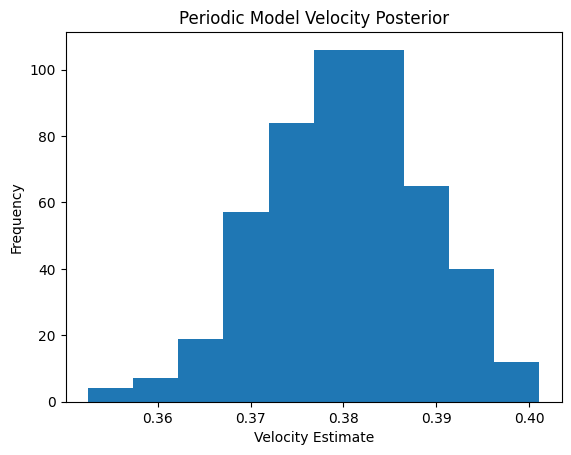

In [45]:
plt.hist(velocity.mean(1))
plt.xlabel("Velocity Estimate")
plt.ylabel("Frequency")
plt.title("Periodic Model Velocity Posterior")
plt.show()

In [47]:
# Cell cycle time in hours
print(2*np.pi/velocity.mean())

16.528259838181253


In [48]:
velocity_fit0 = velocity_fit

In [49]:
pyro.clear_param_store()

In [50]:
condition_design_matrix = copy.deepcopy(batch_design_matrix)

In [51]:
n_velo_harmonics = 1
speed_prior = angularspeed.AngularSpeed.trivial_prior(condition_names=["pancreas_ductal"], harmonics=n_velo_harmonics, 
                                                means=0.0, stds=3.0)

speed_prior.stds.loc["nu1_cos"] = 0.01
speed_prior.stds.loc["nu1_sin"] = 0.01

In [53]:
condition_on_dict = {"ϕxy":phase_pyro.phi_xy_tensor.T,
                     "ν": cycle_pyro.means_tensor.T.unsqueeze(-2),
                     "Δν": torch.tensor(phase_fit.delta_nus),
                     "shape_inv": torch.tensor(phase_fit.disp_pyro).unsqueeze(-1)}

In [54]:
metaparameters_velocity = preprocessing.preprocess_for_velocity_estimation(data_to_fit, 
                                                             cycle_pyro, 
                                                             phase_pyro, 
                                                             speed_prior,
                                                             condition_design_matrix.float(), 
                                                             batch_design_matrix.float(), 
                                                             n_harmonics=n_harm,
                                                             count_factor=metapar.count_factor,
                                                             ω_n_harmonics=n_velo_harmonics,
                                                             μγ=torch.tensor(0.0).detach().clone().float(),
                                                             σγ=torch.tensor(0.5).detach().clone().float(),
                                                             μβ=torch.tensor(2.0).detach().clone().float(),
                                                             σβ=torch.tensor(3.0).detach().clone().float(),
                                                             model_type="lrmn",
                                                             condition_on=condition_on_dict)

In [55]:
velocity_fit = velocity_inference_model.VelocityFitModel(metaparams=metaparameters_velocity, 
                                                         condition_on=condition_on_dict, early_exit=False,
                                                        num_samples=500, n_per_bin=50)

In [56]:
velocity_fit.check_model()

  Trace Shapes:                              
   Param Sites:                              
  Sample Sites:                              
     cells dist              |               
          value          916 |               
     genes dist              |               
          value           61 |               
 harmonics dist              |               
          value            3 |               
conditions dist              |               
          value            1 |               
   batches dist              |               
          value            1 |               
     logγg dist       61   1 |               
          value       61   1 |               
     logβg dist       61   1 |               
          value       61   1 |               
  rho_real dist       61   1 |               
          value       61   1 |               
        γg dist       61   1 |  61   1       
          value              |  61   1       
         ν dist       61   1 |   3

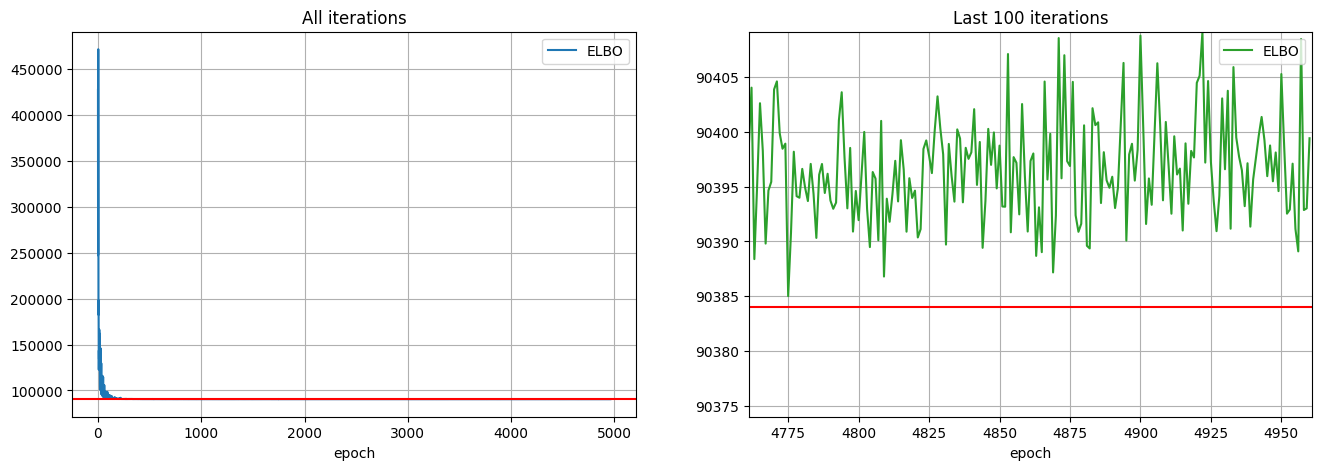

In [57]:
num_steps = 3000
initial_lr = 0.03
final_lr = 0.005
gamma = final_lr / initial_lr
lrd = gamma ** (1 / num_steps)
adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

velocity_fit.fit(optimizer=adam, num_steps=num_steps)

In [58]:
# Put estimations in new objects
cycle_pyro = velocity_fit.cycle_pyro
phase_pyro = velocity_fit.phase_pyro
speed_pyro = velocity_fit.speed_pyro

fit_ElogS = velocity_fit.posterior["ElogS"].squeeze()
fit_ElogU = velocity_fit.posterior["ElogU"].squeeze()

fit_ElogS2 = velocity_fit.posterior["ElogS2"].squeeze()
fit_ElogU2 = velocity_fit.posterior["ElogU2"].squeeze()

log_gammas = velocity_fit.log_gammas
log_betas = velocity_fit.log_betas

In [59]:
# Store entire posterior sampling into an object
full_pps_velo = velocity_fit.posterior

In [60]:
# See the value of the mean gamma
torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy()

array(0.9531931, dtype=float32)

17.340261 1.869181


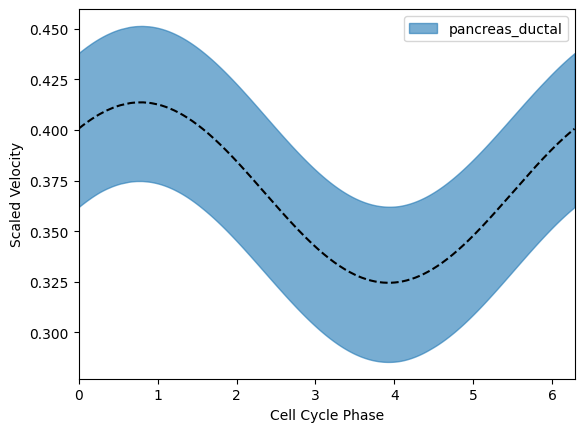

In [62]:
omega = full_pps_velo["ω"].squeeze().numpy() / torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy()
phi = phase_pyro.phis
omegas = []
phis = []
n2n = {"pancreas_ductal":0}
ids = np.array([n2n[i] for i in np.array(data_to_fit.obs["batch"])])
for i in range(len(data_to_fit.obs["batch"].unique())):
    omega1 = omega[:,np.where(ids == i)]
    phi1 = phi[np.where(ids == i)]
    omegas.append(omega1)
    phis.append(phi1)

labels = np.array(data_to_fit.obs["batch"].unique()) #list(adatas.keys())

colors = ["tab:blue"]
for i in range(len(omegas)):
    plt.plot(phis[i][np.argsort(phis[i])], omegas[i].mean(0)[0][np.argsort(phis[i])], c="black", linestyle='dashed')
    
    tmp5 = np.percentile(omega[:, ids==i], 5, axis=0)
    tmp95 = np.percentile(omega[:, ids==i], 95, axis=0)
    print(((2*np.pi)/omega[:, ids==i]).mean(), ((2*np.pi)/omega[:, ids==i]).std())
    phi_i = phi[ids==i] 
    plt.fill_between(x=phi_i[np.argsort(phi_i)],
                     y1=tmp5[np.argsort(phi_i)], 
                     y2=tmp95[np.argsort(phi_i)], 
                     alpha=0.6, color=colors[i], label = labels[i])
plt.xlabel("Cell Cycle Phase")
plt.xlim(0, 2*np.pi)
plt.ylabel("Scaled Velocity")
plt.legend()
plt.show()